**Plots comparison for calibration** 

**LHS SAMPLING**

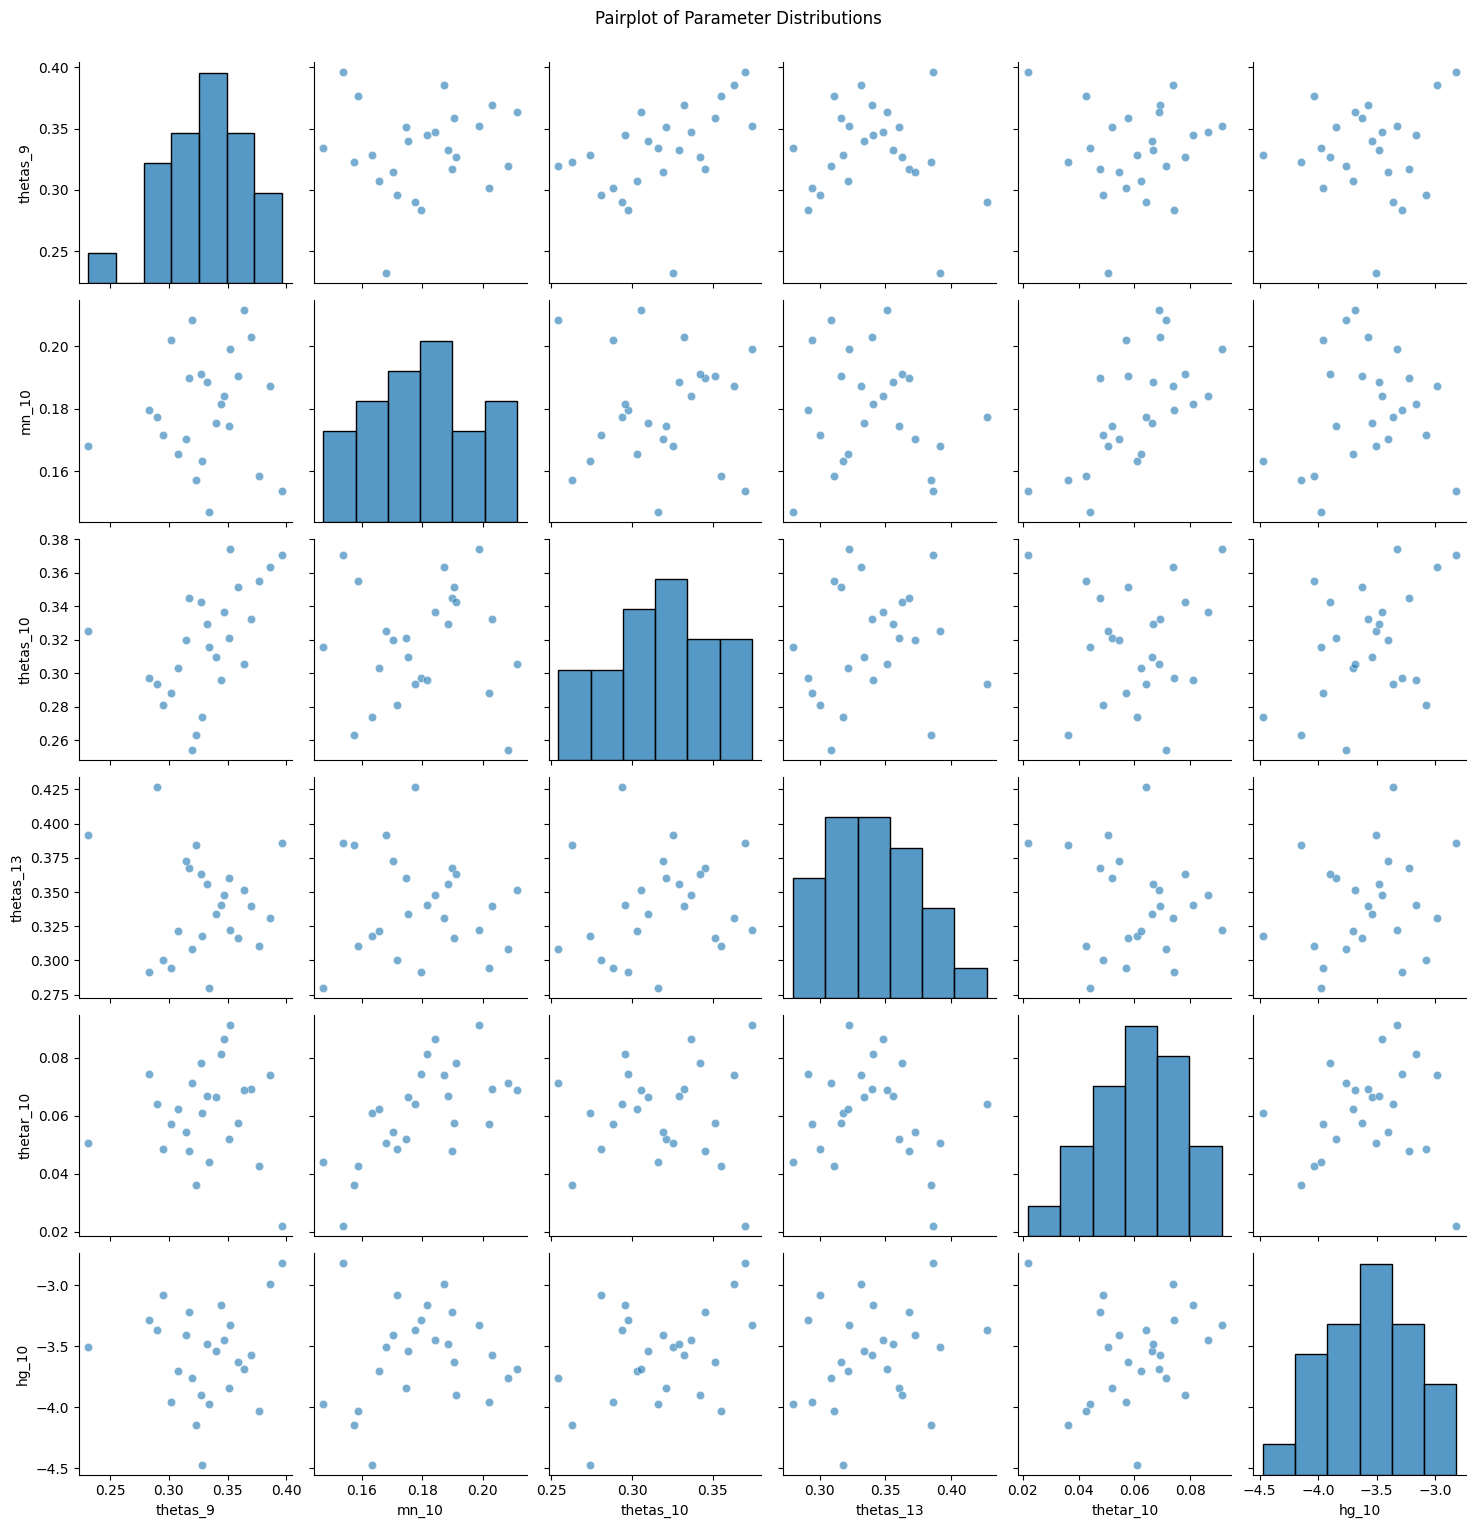

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

x_lhs_path = '/home/tomari/Documents/First_simulation/x_train_test.csv'

x_lhs_df = pd.read_csv(x_lhs_path)

x_lhs_clean = x_lhs_df.drop(x_lhs_df.columns[0], axis=1)

# Create a pairplot to visualize the distributions and relationships between the parameters
sns.pairplot(x_lhs_clean, diag_kind="hist", plot_kws={"alpha": 0.6})

# Set the plot title
plt.suptitle("Pairplot of Parameter Distributions", y=1.02)
plt.show()


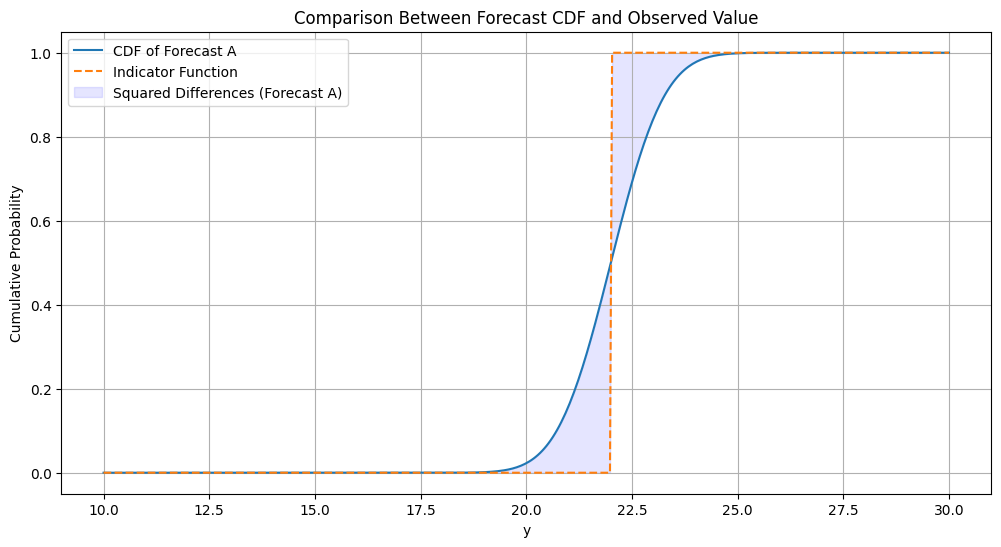

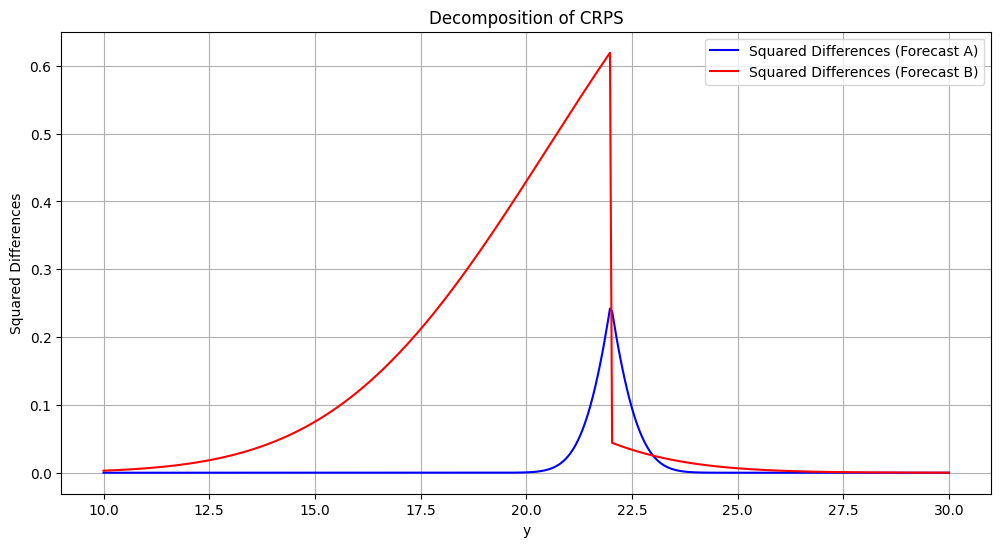

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters for the normal distributions
mu_A, sigma_A = 22, 1
mu_B, sigma_B = 18, 5
observation = 22

# Generate range of values for y
y_values = np.linspace(10, 30, 400)

# Calculate the CDFs
F_A = norm.cdf(y_values, mu_A, sigma_A)
F_B = norm.cdf(y_values, mu_B, sigma_B)

# Indicator function for the observed value
indicator = (y_values >= observation).astype(float)

# Calculate the differences squared
diff_A = (F_A - indicator) ** 2
diff_B = (F_B - indicator) ** 2

# Plot 1: Comparison Between Forecast CDF and Observed Value
plt.figure(figsize=(12, 6))
plt.plot(y_values, F_A, label='CDF of Forecast A')
plt.plot(y_values, indicator, label='Indicator Function', linestyle='--')
plt.fill_between(y_values, F_A, indicator, color='blue', alpha=0.1, label='Squared Differences (Forecast A)')
plt.title('Comparison Between Forecast CDF and Observed Value')
plt.xlabel('y')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Decomposition of CRPS
plt.figure(figsize=(12, 6))
plt.plot(y_values, diff_A, label='Squared Differences (Forecast A)', color='blue')
plt.plot(y_values, diff_B, label='Squared Differences (Forecast B)', color='red')
plt.title('Decomposition of CRPS')
plt.xlabel('y')
plt.ylabel('Squared Differences')
plt.legend()
plt.grid(True)
plt.show()


**Metrics for measuring the calibration accuaracy and comparison between methods(EI, LCB, REG)**

In [62]:
import numpy as np 
import pandas as pd 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from properscoring import crps_ensemble
import properscoring as ps
# Importing data from paths for paramters x 

x_true_path = '/home/tomari/Documents/First_simulation/x_true.csv'

x_optimals_path = '/home/tomari/Documents/First_simulation/x_optimals_Tarek_EI_reg.csv'

# Importing data from paths for profiles y 

y_optimals_path = '/home/tomari/Documents/First_simulation/y_optimals_Tarek_reg.csv'

y_obs_list_path = '/home/tomari/Documents/First_simulation/y_obs_all_list.csv'

# Import data as dataframes

x_true_df = pd.read_csv(x_true_path)

x_optimals_df = pd.read_csv(x_optimals_path) 

# Import data as data frames for profiles y 

y_optimals_df = pd.read_csv(y_optimals_path)

y_obs_values_df = pd.read_csv(y_obs_list_path)

# Extract paramter names 

parameters = x_true_df['Unnamed: 0'].values

# Clean data from usless column                

x_true_clean = x_true_df.drop(x_true_df.columns[0], axis=1)

y_optimals_clean = y_optimals_df.drop(y_optimals_df.columns[0], axis=1) 

y_obs_values_clean = y_obs_values_df.drop(y_obs_values_df.columns[0], axis=1) 

x_optimals_clean = x_optimals_df.drop(x_optimals_df.columns[[0,7]], axis=1)

#for param in paramters: 
    
x_true = x_true_clean.values.flatten()

x_optimals = x_optimals_clean.values

y_optimals = y_optimals_clean.values

y_obs_values = y_obs_values_clean.values

x_true_scaled= np.zeros(len(x_true_clean))

# standardize x_true

x_mean = np.array([0.3322, 0.1791, 0.316, 0.3375, 0.0612, -3.56])

x_std = np.array([0.03322, 0.0179, 0.0316, 0.033, 0.0153, 0.356])

#another method for normalizing 

x_true_scali = ((x_true - x_mean )/ x_std) 

x_optimals_scali = ((x_optimals - x_mean) / x_std) 

# normalizing data 

std_dev = np.std(x_optimals, axis =0)

x_optimals_norm = x_optimals / x_std

#standardize data

scaler = StandardScaler()

scaler.fit(x_optimals)


x_optimals_scaled = scaler.fit_transform(x_optimals_clean)

y_errors = []


for i in range(len(x_true_clean)):
                   
    x_scaled = ((x_true[i] - scaler.mean_[i]) / scaler.scale_[i])
    
    x_true_scaled[i] = x_scaled

for k in range(len(y_optimals)):

    y_error = (y_optimals[k] - y_obs_values[k])**2
    
    y_errors.append(y_error)
    
    y_mse = np.mean(y_errors)
    
    y_rmse = np.sqrt(y_mse)


print('the MSE for the moisture profile y is :', y_mse)

print('the RMSE for the moisture profile y is :', y_rmse)

# Wrtiing the results in a csv files

metrics_y_df = pd.DataFrame({
    'error metrics': ['metrics'], 
    'MSE': y_mse,
    'RMSE': y_rmse
})

metrics_y_df.to_csv('/home/tomari/Documents/First_simulation/metrics_results_y_EI_reg.csv', index=False)

print("Metrics saved to '/home/tomari/Documents/First_simulation/metrics_results_EI_y.csv'")

# Reconversion to data frames 

x_true_scaled_df = pd.DataFrame(x_true_scali, columns = x_true_clean.columns) 

x_optimals_scaled_df = pd.DataFrame(x_optimals_scali, columns = x_optimals_clean.columns)

# Creation of lists for the metrics 

# Applying the metrics on the scaled data for both x_true and x_optimals 

mse_1_list = []
rmse_list = []
crps_list = []

# Manual 

for params, true_value in zip(parameters,x_true_scali): 

    optimals = x_optimals_scaled_df[params]
    
    mse = np.mean((optimals - true_value)**2)
    
    rmse=np.sqrt(mse)

    crps = ps.crps_ensemble(true_value, optimals.values)
    #rmse = np.sqrt(mse)
      
    mse_1_list.append(mse)
    rmse_list.append(rmse)
    crps_list.append(crps)
    

print('The MSE IS  : ', mse_1_list)
print('The RMSE IS  : ', rmse_list)
print('The CRPS IS : ', crps_list)

# Create a DataFrame for the MSE and RMSE

metrics_df = pd.DataFrame({
    'Parameter': parameters,
    'MSE': mse_1_list,
    'RMSE': rmse_list,
    'CRPS': crps_list
})

# Save the DataFrame to a CSV file
metrics_df.to_csv('/home/tomari/Documents/First_simulation/metrics_results_EI_reg.csv', index=False)

print("Metrics saved to '/home/tomari/Documents/First_simulation/metrics_results_EI_reg.csv'")

the MSE for the moisture profile y is : 0.002504644426334077
the RMSE for the moisture profile y is : 0.050046422712658266
Metrics saved to '/home/tomari/Documents/First_simulation/metrics_results_EI_y.csv'
The MSE IS  :  [0.13703507337528772, 0.23852440489287557, 0.1350795927473708, 0.10923873547165051, 1.0966903596132132, 5.235517127543392]
The RMSE IS  :  [0.37018248658639663, 0.4883896035880326, 0.3675317574678014, 0.33051283707543117, 1.047229850421202, 2.288125242975872]
The CRPS IS :  [0.16013392397967635, 0.4232029063946791, 0.046558791031688876, 0.08126451912098678, 0.9927906270395997, 2.1988332461779643]
Metrics saved to '/home/tomari/Documents/First_simulation/metrics_results_EI_reg.csv'


**Metrics for measuring trialling**

In [22]:
import numpy as np 
import pandas as pd 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from properscoring import crps_ensemble

# Importing data from paths for paramters x 

x_true_path = '/home/tomari/Documents/First_simulation/x_true.csv'

x_optimals_path = '/home/tomari/Documents/First_simulation/x_optimals_Tarek_EI.csv'

# Importing data from paths for profiles y 

y_optimals_path = '/home/tomari/Documents/First_simulation/y_optimals_Tarek_reg.csv'

y_obs_list_path = '/home/tomari/Documents/First_simulation/y_obs_all_list.csv'

# Import data as dataframes

x_true_df = pd.read_csv(x_true_path)

x_optimals_df = pd.read_csv(x_optimals_path) 

# Import data as data frames for profiles y 

y_optimals_df = pd.read_csv(y_optimals_path)

y_obs_values_df = pd.read_csv(y_obs_list_path)

# Extract paramter names 

parameters = x_true_df['Unnamed: 0'].values

# Clean data from usless column                

x_true_clean = x_true_df.drop(x_true_df.columns[0], axis=1)

y_optimals_clean = y_optimals_df.drop(y_optimals_df.columns[0], axis=1) 

y_obs_values_clean = y_obs_values_df.drop(y_obs_values_df.columns[0], axis=1) 

x_optimals_clean = x_optimals_df.drop(x_optimals_df.columns[[0,7]], axis=1)

#for param in paramters: 
    
x_true = x_true_clean.values.flatten()

x_optimals = x_optimals_clean.values

y_optimals = y_optimals_clean.values

y_obs_values = y_obs_values_clean.values

x_true_scaled= np.zeros(len(x_true_clean))


# standardize x_true

x_mean = np.array([0.3322, 0.1791, 0.316, 0.3375, 0.0612, -3.56])

x_std = np.array([0.03322, 0.0179, 0.0316, 0.033, 0.0153, 0.356])

#another method for normalizing 

x_true_scali = ((x_true - x_mean )/ x_std) 

x_optimals_scali = ((x_optimals - x_mean) / x_std) 

# normalizing data 

std_dev = np.std(x_optimals, axis =0)

x_optimals_norm = x_optimals / x_std

#standardize data

scaler = StandardScaler()

scaler.fit(x_optimals)

x_optimals_scaled = scaler.fit_transform(x_optimals_clean)

y_errors = []


for i in range(len(x_true_clean)):
                   
    x_scaled = ((x_true[i] - scaler.mean_[i]) / scaler.scale_[i])
    
    x_true_scaled[i] = x_scaled

for k in range(len(y_optimals)):

    y_error = (y_optimals[k] - y_obs_values[k])**2
    
    y_errors.append(y_error)
    
    y_mse = np.mean(y_errors)
    
    y_rmse = np.sqrt(y_mse)


print('the MSE for the moisture profile y is :', y_mse)

print('the RMSE for the moisture profile y is :', y_rmse)

# Wrtiing the results in a csv files

metrics_y_df = pd.DataFrame({
    'error metrics': ['metrics'], 
    'MSE': y_mse,
    'RMSE': y_rmse
})

metrics_y_df.to_csv('/home/tomari/Documents/First_simulation/metrics_results_EI_reg_y.csv', index=False)

print("Metrics saved to '/home/tomari/Documents/First_simulation/metrics_results_reg_y.csv'")

# Reconversion to data frames 

x_true_scaled_df = pd.DataFrame(x_true_scali, columns = x_true_clean.columns) 

x_optimals_scaled_df = pd.DataFrame(x_optimals_scali, columns = x_optimals_clean.columns)

# Creation of lists for the metrics 

# Applying the metrics on the scaled data for both x_true and x_optimals 

mse_1_list = []
rmse_list = []
crps_list = []

# Manual 

for params, true_value in zip(parameters,x_true_scali): 

    optimals = x_optimals_scaled_df[params]
    
    mse = np.mean((optimals - true_value)**2)
    
    rmse=np.sqrt(mse)

    crps = crps_ensemble(true_value, optimals.values)
    #rmse = np.sqrt(mse)
      
    mse_1_list.append(mse)
    rmse_list.append(rmse)
    crps_list.append(np.mean(crps))
    

print('The MSE IS  : ', mse_1_list)
print('The RMSE IS  : ', rmse_list)
print('The CRPS IS : ', crps_list)

# Create a DataFrame for the MSE and RMSE

metrics_df = pd.DataFrame({
    'Parameter': parameters,
    'MSE': mse_1_list,
    'RMSE': rmse_list,
    'CRPS': crps_list
})

# Save the DataFrame to a CSV file
metrics_df.to_csv('/home/tomari/Documents/First_simulation/metrics_results_EI.csv', index=False)

print("Metrics saved to '/home/tomari/Documents/First_simulation/metrics_results_EI_reg.csv'")

the MSE for the moisture profile y is : 0.00014361180198350953
the RMSE for the moisture profile y is : 0.011983814166762998
Metrics saved to '/home/tomari/Documents/First_simulation/metrics_results_reg_y.csv'
The MSE IS  :  [0.15024448344019908, 0.3245039236694237, 0.2948637470856771, 0.36815500717271465, 1.413630086126607, 3.5039847127965302]
The RMSE IS  :  [0.3876138328803541, 0.5696524586705685, 0.5430135790987893, 0.606757782951908, 1.18896176815178, 1.8718933497388495]
The CRPS IS :  [0.06540743985801178, 0.47544404634434645, 0.12547926611760712, 0.06366302745971186, 0.979793931098726, 0.839266432185801]
Metrics saved to '/home/tomari/Documents/First_simulation/metrics_results_EI_reg.csv'


**Convergence Plot**

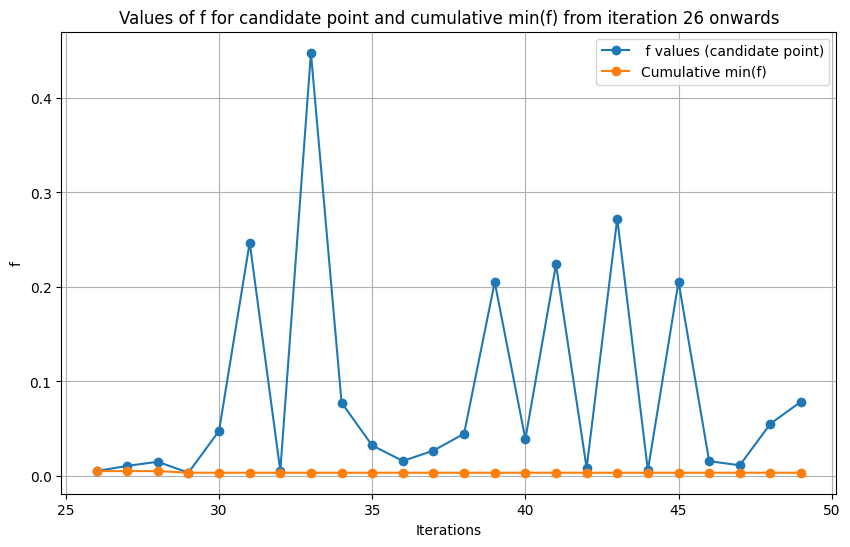

In [50]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

# importing correspondante data for the plotting 

f_values_path = '/home/tomari/Documents/First_simulation/f_values_list_reg.csv'

# Extracting the data 

f_values_df = pd.read_csv(f_values_path)

# Reduce the f values to 25 only 

f_values_adjusted = f_values_df.iloc[25:].reset_index(drop=True)

# Calculate the  cumulative minimum of f for each iteration

min_f_per_iteration = f_values_adjusted['F'].cummin()

# Representation of the potential minimum of f and cumultaive min(f) alongside the iteration process 

plt.figure(figsize=(10, 6))
plt.plot(f_values_adjusted['Unnamed: 0'], f_values_adjusted['F'], marker='o',label=' f values (candidate point)')
plt.plot(f_values_adjusted['Unnamed: 0'], min_f_per_iteration, marker='o', label='Cumulative min(f)')
plt.xlabel('Iterations')
plt.ylabel('f')
plt.title('Values of f for candidate point and cumulative min(f) from iteration 26 onwards')
plt.legend()
plt.grid(True)
plt.show()

**Part One : Importing a CSV File in order to save x_optimals file for all rainfalls (198)**

In [58]:
import numpy as np
from scipy.stats import norm
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
from skopt import gp_minimize
from skopt.space import Real
import matplotlib.pyplot as plt
import warnings
import csv 
import os  

# Load the provided data files

x_true_path = '/home/tomari/Documents/First_simulation/x_true.csv'

x_true_df = pd.read_csv(x_true_path)

x_true_clean = x_true_df.drop(x_true_df.columns[0], axis=1)

x_true = x_true_clean.values.flatten()

x_true_values = x_true.tolist()

# Définissez votre chemin d'accès au dossier contenant vos fichiers CSV

Calibration_data_path = "/home/tomari/Documents/OUTPUT_C_EI"

# The number of files i have 

n_files = 198

# Array for the x_optimal values 

f_robust_values = []

x_robust_values = []

y_robust_values = []

y_obs_values = [] 

for i in range(n_files):
    
    # Générez les noms de fichiers pour x_train et y_train
    x_train_file = f"x_train{i}.csv"
    y_train_file = f"y_train{i}.csv"
    y_obs_file = f"y_obs{i}.csv"
    
    # Chemins complets des fichiers
    x_train_path = os.path.join(Calibration_data_path , x_train_file)
    y_train_path = os.path.join(Calibration_data_path , y_train_file)
    y_obs_path =  os.path.join(Calibration_data_path , y_obs_file)
    
    # Load the data from the provided CSV files
    
    x_train_df = pd.read_csv(x_train_path)
    y_train_df = pd.read_csv(y_train_path)
    y_obs_df = pd.read_csv(y_obs_path)
    
    #Clean data
    
    x_train_df = x_train_df.drop(x_train_df.columns[0], axis=1)
    
    y_train_df= y_train_df.drop(y_train_df.columns[0], axis=1)
    
    y_obs_df = y_obs_df.drop(y_obs_df.columns[0], axis=1)
    
    # Convert DataFrames to numpy arrays
    
    y_train = y_train_df.values

    y_obs = y_obs_df.values 
 
    x_train = x_train_df.values

    y_obs_list = y_obs.tolist()
    
    x_train_mn = x_train[:,1]

    x_train_tr = x_train[:,4]
    
    if len(x_train) and len(y_train) >= 25: 
    
        #Conversion of x_train to a list 
    
        x_train_list_old = x_train.tolist() 
    
        # Assuming x_train is a NumPy array with shape (50, 6)
        
        x_train_list = x_train.tolist()

        # Converting y_train to a list 

        y_train_list = y_train.tolist()
    
        # Compute MSE for each block
    
        def cost(y_train):
        
            # Initialize an array to store the MSE for each block
            cost_rain = np.zeros((len(x_train)))
            
            for j in range(len(y_train)):
                # Compute the MSE between the block and the corresponding observation
                F = (
                np.sum((y_train[j] - y_obs)**2) +
                0*8e-3*(np.sum(((x_train_mn[j] - 0.1791) / 0.0179)**2) +
                np.sum(((x_train_tr[j] - 0.0612) / 0.0153)**2))
                )
                # Store the MSE in the appropriate index of the global_costs_on_rains array
                cost_rain[j] = F
            
            return cost_rain
        
        # the evaluations of the cost function on 50 parameter set 
    
        f_values = cost(y_train)
        
        #Conversion to a list 
        
        f_values_list = f_values.tolist() 
        
        # Find the index of the minimum value in f_values_list
        
        min_index = np.argmin(f_values_list)

        # creating y_obs list 
        
        y_true = y_obs_list[0]        
        
        y_obs_values.append(y_true)

        # import y_optimal 
        
        y_optimal = y_train_list[min_index-1]

        y_robust_values.append(y_optimal)

        # list f values 
            
        f_robust_values.append(np.min(f_values_list))
        
        # Retrieve the corresponding x_train_list element
        
        optimal_x_train = x_train_list[min_index]
    
        # stocking the optimal values
        
        x_robust_values.append(optimal_x_train)

        #print(np.shape(f_values_list))
        #print(f_values_list)
    else: 

        print(f"file {i} is not fully enriched")
    
# param names 

parameter_names = ["thetas_9","mn_10", "thetas_10", "thetas_13","thetar_10","hg_10"]

# Convert the list of dictionaries to a DataFrame

f_values_graph = pd.DataFrame(f_values_list, columns = ['F'])

x_optimals_Tarek = pd.DataFrame(x_robust_values, columns=parameter_names)

y_optimals_Tarek = pd.DataFrame(y_robust_values)

y_obs_Tarek = pd.DataFrame(y_obs_values)

x_optimals_Tarek["Output"] = f_robust_values


# Specify the file path where you want to save the CSV file
file_path_x = '/home/tomari/Documents/First_simulation/x_optimals_Tarek_EI.csv'

file_path_f = '/home/tomari/Documents/First_simulation/f_values_list.csv'

file_path_y = '/home/tomari/Documents/First_simulation/y_optimals_Tarek.csv'

file_path_y_obs = '/home/tomari/Documents/First_simulation/y_obs_all_list.csv'

x_optimals_Tarek.index = x_optimals_Tarek.index + 1

f_values_graph.index = f_values_graph.index + 1 

y_optimals_Tarek.index = y_optimals_Tarek.index + 1 

y_obs_Tarek.index = y_obs_Tarek.index + 1 

# Save the DataFrame to a CSV file

x_optimals_Tarek.to_csv(file_path_x, index=True) 

f_values_graph.to_csv(file_path_f, index =True)

y_optimals_Tarek.to_csv(file_path_y, index = True)

y_obs_Tarek.to_csv(file_path_y_obs, index =True)


print("DataFrame saved as CSV file:", file_path_x)

print("DataFrame saved as CSV file:", file_path_f)

#print("DataFrame saved as CSV file:", file_path_y)

print("DataFrame saved as CSV file:", file_path_y_obs)



DataFrame saved as CSV file: /home/tomari/Documents/First_simulation/x_optimals_Tarek_EI.csv
DataFrame saved as CSV file: /home/tomari/Documents/First_simulation/f_values_list.csv
DataFrame saved as CSV file: /home/tomari/Documents/First_simulation/y_obs_all_list.csv


**Part two : Plotting the comparison with the histogrammes of x_optimals over the rainfalls**

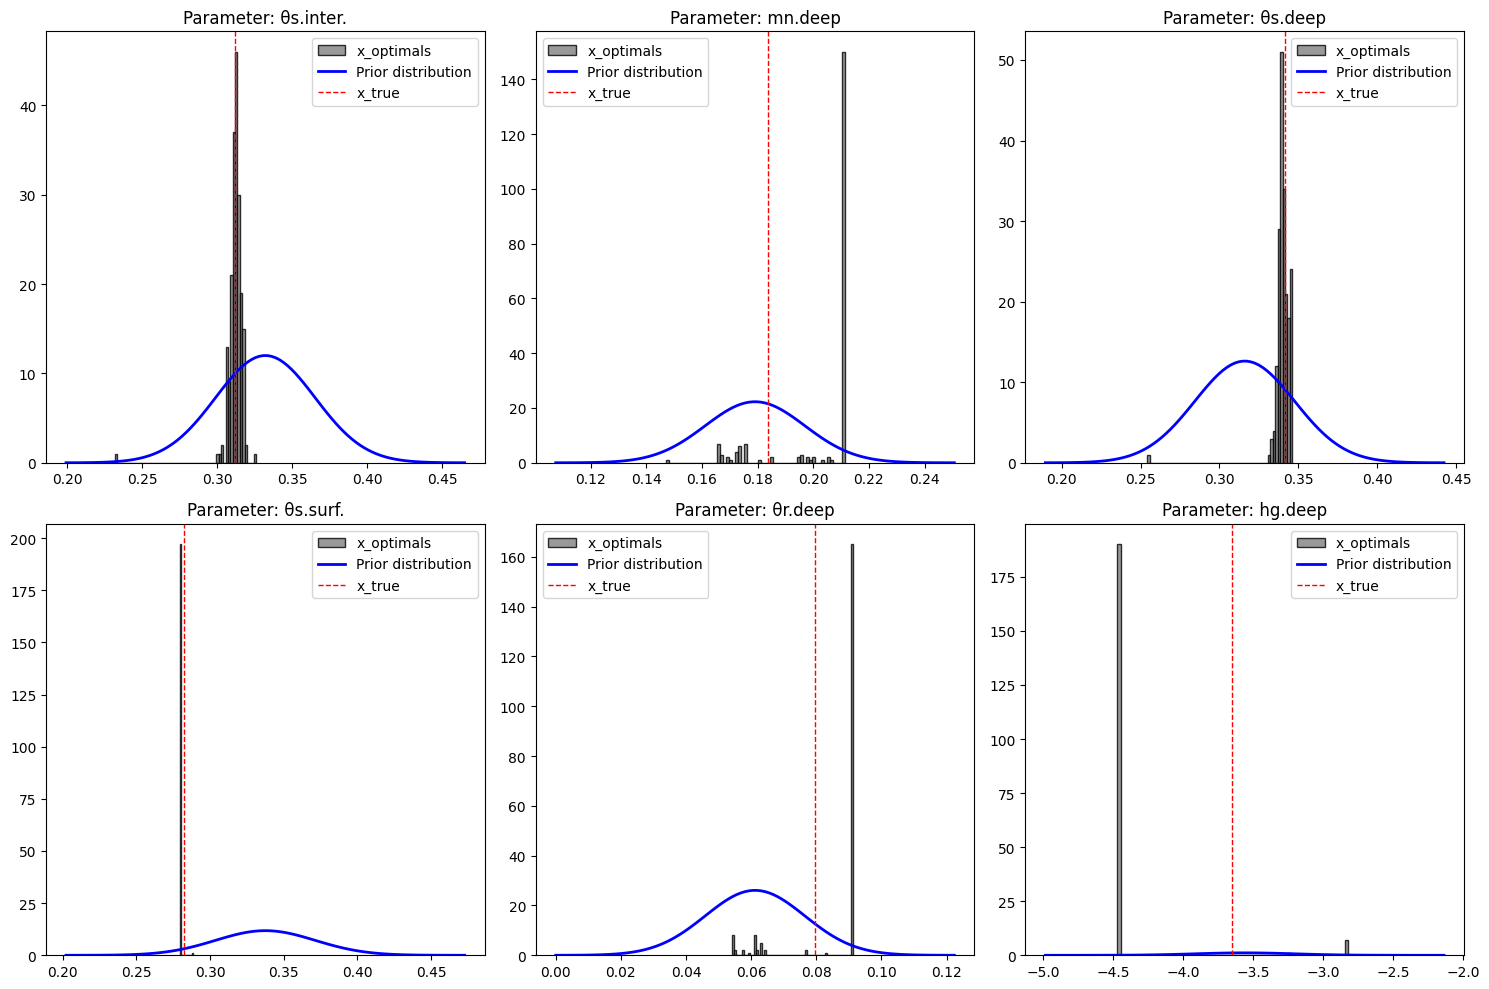

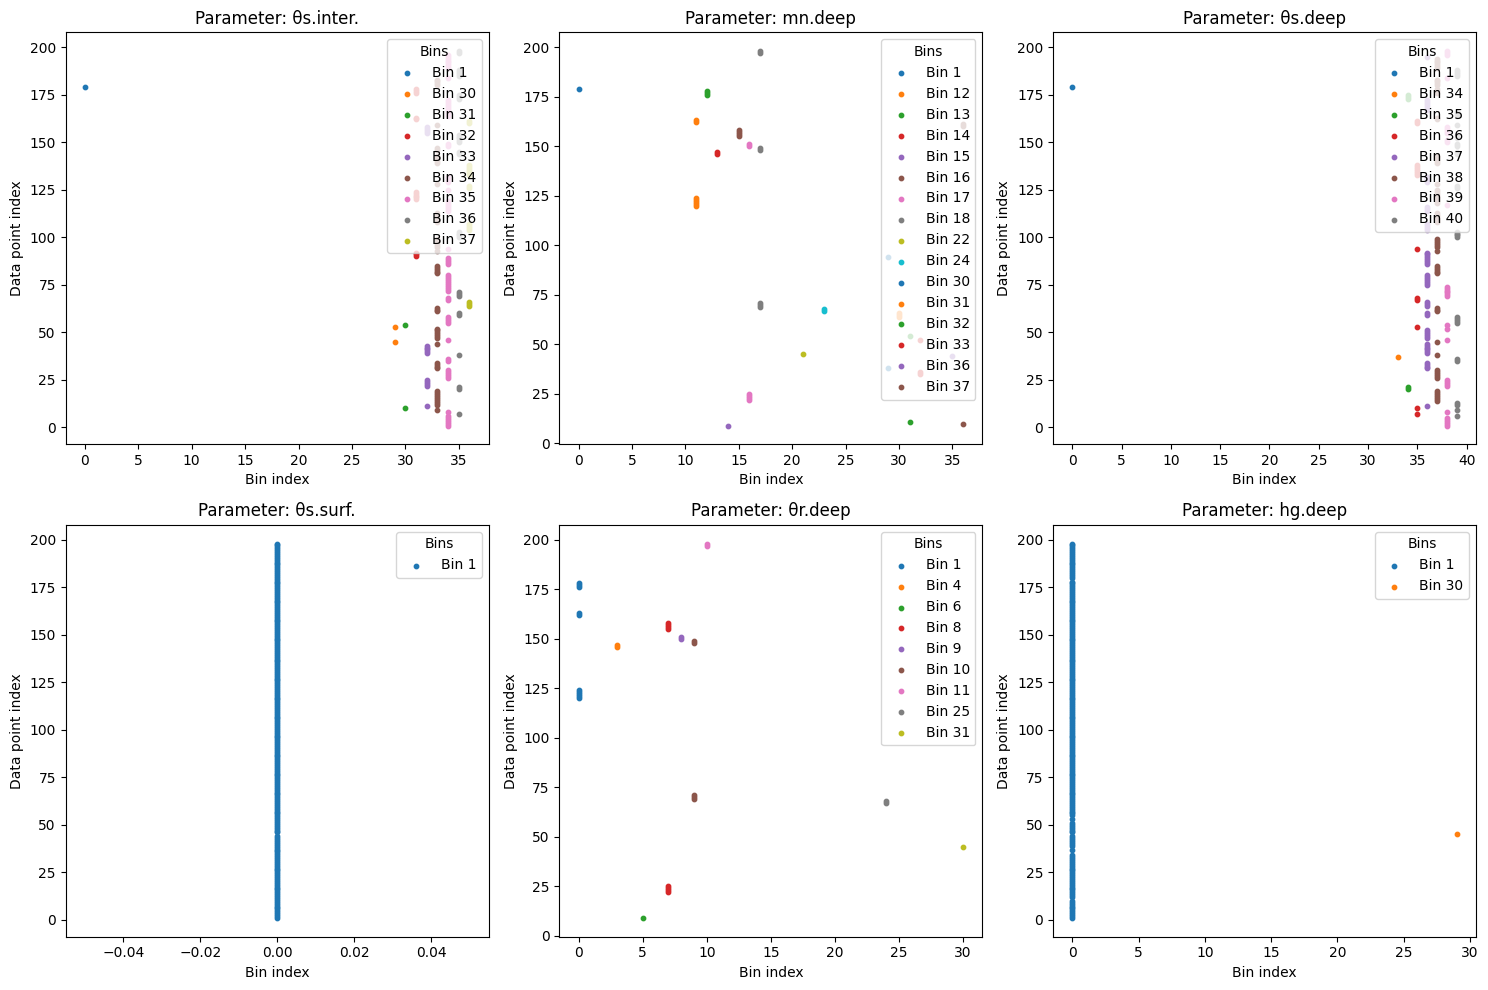

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load the provided data files
x_true_path = '/home/tomari/Documents/First_simulation/x_true.csv'
x_true_df = pd.read_csv(x_true_path)
x_true_clean = x_true_df.drop(x_true_df.columns[0], axis=1)
x_true = x_true_clean.values.flatten()

x_optimals_path = '/home/tomari/Documents/First_simulation/x_optimals_Tarek_EI.csv'  # Path to the uploaded file
x_optimals_df = pd.read_csv(x_optimals_path)
x_optimals_cl = x_optimals_df.drop(x_optimals_df.columns[[0, -1]], axis=1)
x_optimals = x_optimals_cl.values

# Define parameter distributions
param_distributions = [
    ('θs.inter.', 0.3322, 0.03322**2),
    ('mn.deep', 0.1791, 0.0179**2),
    ('θs.deep', 0.316, 0.0316**2),
    ('θs.surf.', 0.3375, 0.0338**2),
    ('θr.deep', 0.0612, 0.0153**2),
    ('hg.deep', -3.56, 0.356**2)
]

# Plot histograms and prior distributions for each parameter
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (param_name, mean, var) in enumerate(param_distributions):
    ax = axes[i]

    # Plot histogram of x_optimals
    counts, bins, patches = ax.hist(x_optimals[:, i], bins=60, density=False, alpha=0.8, color='gray', edgecolor='black', label='x_optimals')

    # Plot the prior distribution
    x = np.linspace(mean - 4 * np.sqrt(var), mean + 4 * np.sqrt(var), 100)
    y = norm.pdf(x, mean, np.sqrt(var))
    ax.plot(x, y, 'b-', lw=2, label='Prior distribution')

    # Plot the x_true value as a vertical line
    ax.axvline(x_true[i], color='r', linestyle='--', lw=1, label='x_true')

    ax.set_title(f'Parameter: {param_name}')
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Create a separate plot showing which indices correspond to which bins for each parameter
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (param_name, _, _) in enumerate(param_distributions):
    ax = axes[i]

    # Create histogram to get bins
    counts, bins = np.histogram(x_optimals[:, i], bins=40)

    # Map each x_optimal to a bin
    bin_indices = np.digitize(x_optimals[:, i], bins) - 1

    # Create a plot showing indices
    for bin_idx in range(len(bins) - 1):
        indices = np.where(bin_indices == bin_idx)[0] + 1  # Adding 1 to start indices from 1 instead of 0
        if len(indices) > 0:
            ax.scatter([bin_idx] * len(indices), indices, label=f'Bin {bin_idx + 1}', s=10)

    ax.set_title(f'Parameter: {param_name}')
    ax.set_xlabel('Bin index')
    ax.set_ylabel('Data point index')
    ax.legend(title='Bins', loc='upper right')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


**L-BFGS-B ALgorithm trailling**

In [2]:
import numpy as np
from scipy.optimize import minimize

# Define the function
def func(x):
    return (x[0] - 1)**2 + (x[1] - 2)**2

# Define the gradient
def func_grad(x):
    return np.array([2 * (x[0] - 1), 2 * (x[1] - 2)])

# Initial guess
x0 = np.array([0.0, 0.0])

# Bounds
bounds = [(0, 2), (0, 3)]

# Run the L-BFGS-B algorithm
result = minimize(func, x0, method='L-BFGS-B', jac=func_grad, bounds=bounds)

# Output the result
print("Optimal value of x:", result.x)
print("Minimum value of the function:", result.fun)
print(result)

Optimal value of x: [1. 2.]
Minimum value of the function: 0.0
  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.0
        x: [ 1.000e+00  2.000e+00]
      nit: 2
      jac: [ 0.000e+00  0.000e+00]
     nfev: 3
     njev: 3
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


In [13]:
import numpy as np

# Sample data
data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Calculating percentiles
p25 = np.percentile(data, 25)  # 25th percentile
p50 = np.percentile(data, 50)  # 50th percentile (median)
p75 = np.percentile(data, 75)  # 75th percentile

print("25th percentile:", p25)
print("50th percentile:", p50)
print("75th percentile:", p75)


G3JLgvDmmC

25th percentile: 3.25
50th percentile: 5.5
75th percentile: 7.75


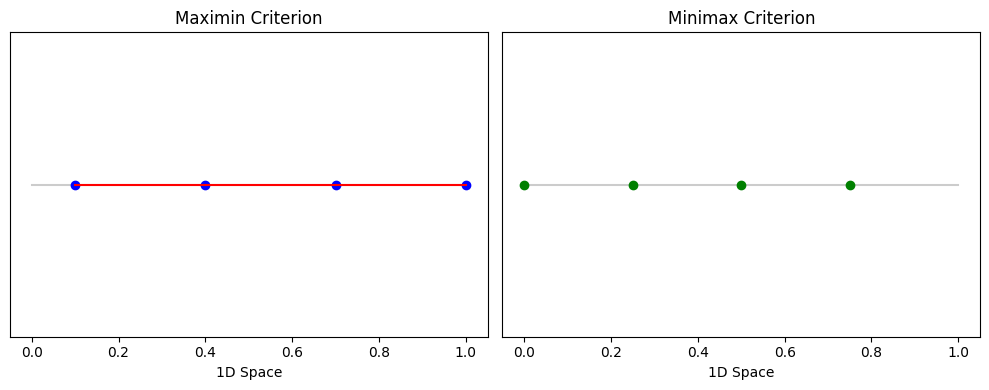

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Define the range of the 1D space
x_range = np.linspace(0, 1, 1000)

# Define the points for Maximin and Minimax
maximin_points = [0.1, 0.4, 0.7, 1.0]
minimax_points = [0.0, 0.25, 0.5, 0.75]

# Plotting
plt.figure(figsize=(10, 4))

# Maximin plot
plt.subplot(1, 2, 1)
plt.plot(x_range, [0] * len(x_range), 'k-', alpha=0.2)
plt.plot(maximin_points, [0] * len(maximin_points), 'bo', label='Design Points')
plt.title('Maximin Criterion')
plt.ylim(-0.1, 0.1)
plt.yticks([])
for i in range(len(maximin_points) - 1):
    plt.plot([maximin_points[i], maximin_points[i+1]], [0, 0], 'r-')
plt.xlabel('1D Space')

# Minimax plot
plt.subplot(1, 2, 2)
plt.plot(x_range, [0] * len(x_range), 'k-', alpha=0.2)
plt.plot(minimax_points, [0] * len(minimax_points), 'go', label='Design Points')
plt.title('Minimax Criterion')
plt.ylim(-0.1, 0.1)
plt.yticks([])
for point in x_range[::250]:
    nearest_distance = min(abs(np.array(minimax_points) - point))
    plt.plot([point, point], [0, -nearest_distance], 'g--')
plt.xlabel('1D Space')

plt.tight_layout()
plt.show()


**Minimum calculus for one rain**

In [37]:
import numpy as np
from scipy.stats import norm
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
from skopt import gp_minimize
from skopt.space import Real
import matplotlib.pyplot as plt
import warnings
import csv 
import os  

# Load the provided data files

x_true_path = '/home/tomari/Documents/First_simulation/x_true.csv'

x_true_df = pd.read_csv(x_true_path)

x_true_clean = x_true_df.drop(x_true_df.columns[0], axis=1)

x_true = x_true_clean.values.flatten()

x_true_values = x_true.tolist()

# Définissez votre chemin d'accès au dossier contenant vos fichiers CSV

Calibration_data_path = "/home/tomari/Documents/First_simulation"

# The number of files i have

j ='_trial'

n_files = 1

# Array for the x_optimal_values

f_robust_values = []

x_robust_values = []


for i in range(n_files):

    # Générez les noms de fichiers pour x_train et y_train
    x_train_file = f"x_train{j}.csv"
    y_train_file = f"y_train{j}.csv"
    y_obs_file = f"y_obs{j}.csv"
    
    # Chemins complets des fichiers
    x_train_path = os.path.join(Calibration_data_path , x_train_file)
    y_train_path = os.path.join(Calibration_data_path , y_train_file)
    y_obs_path =  os.path.join(Calibration_data_path , y_obs_file)
    
    # Load the data from the provided CSV files
    
    x_train_df = pd.read_csv(x_train_path)
    y_train_df = pd.read_csv(y_train_path)
    y_obs_df = pd.read_csv(y_obs_path)
    
    #Clean data
    
    x_train_df = x_train_df.drop(x_train_df.columns[0], axis=1)
    
    #y_train_df= y_train_df.drop(y_train_df.columns[0], axis=1)
    
    #y_obs_df = y_obs_df.drop(y_obs_df.columns[0], axis=1)
    
    # Convert DataFrames to numpy arrays
    
    y_train = y_train_df.values

    y_obs = y_obs_df.values 
 
    x_train = x_train_df.values

    x_train_mn = x_train[:,1]

    x_train_tr = x_train[:,4]
    
    if len(x_train) >= 48:
    
        #Conversion of x_train to a list 
        
        x_train_list_old = x_train.tolist() 
        
        # Assuming x_train is a NumPy array with shape (50, 6)
        x_train_list = x_train.tolist()
        
        
        # Compute MSE for each block
        
        def cost(y_train, x_train_mn, x_train_tr):
             
            # Initialize an array to store the MSE for each block
            
            cost_on_one_rain = np.zeros((len(x_train)))
            
            
            for j in range(len(x_train)):
                
                  #if j <= 25: 
                  # Compute the MSE between the block and the corresponding observation
                  #F = (np.sum((y_train[j] - y_obs)**2))
                  #else: 
                  # Compute the MSE between the block and the corresponding observation
                  F = (
                    np.sum((y_train[j] - y_obs)**2) + 
                    4e-2*(np.sum(((x_train_mn[j] - 0.1791) / 0.0179)**2) +
                    np.sum(((x_train_tr[j] - 0.0612) / 0.0153)**2))
                  )
                  # Store the MSE in the appropriate index of the global_costs_on_rains array
                  cost_on_one_rain[j] = F
            
            return cost_on_one_rain
        
        # the evaluations of the cost function on 50 parameter set 
        
        f_values = cost(y_train, x_train_mn, x_train_tr)
        
        
        #Conversion to a list 
        
        f_values_list = f_values.tolist()
        
        # Find the index of the minimum value in f_values_list
        
        
        min_index = np.argmin(f_values_list)

        print(min_index)
        
        f_robust_values.append(np.min(f_values_list))
        
        # Retrieve the corresponding x_train_list element
        
        optimal_x_train = x_train_list[min_index]
        
        # stocking the optimal values
        x_robust_values.append(optimal_x_train)

    else: 

        print(f"file {i} is not fully enriched")
    
# param names 

parameter_names = ["thetas_9","mn_10", "thetas_10", "thetas_13","thetar_10","hg_10"]

# Convert the list of dictionaries to a DataFrame
x_optimals_Tarek = pd.DataFrame(x_robust_values, columns=parameter_names)

x_optimals_Tarek["Output"] = f_robust_values


# Specify the file path where you want to save the CSV file
file_path = f"/home/tomari/Documents/First_simulation/x_optimals{j}.csv"

x_optimals_Tarek.index = x_optimals_Tarek.index + 1


# Save the DataFrame to a CSV file
 
x_optimals_Tarek.to_csv(file_path, index=True) 


print("DataFrame saved as CSV file:", file_path)

print(x_robust_values)

29
DataFrame saved as CSV file: /home/tomari/Documents/First_simulation/x_optimals_trial.csv
[[0.3121401536871561, 0.1786456301319416, 0.3447790791268736, 0.279840011079228, 0.061384639968157, -2.81895948290551]]


**Calibration plotting**

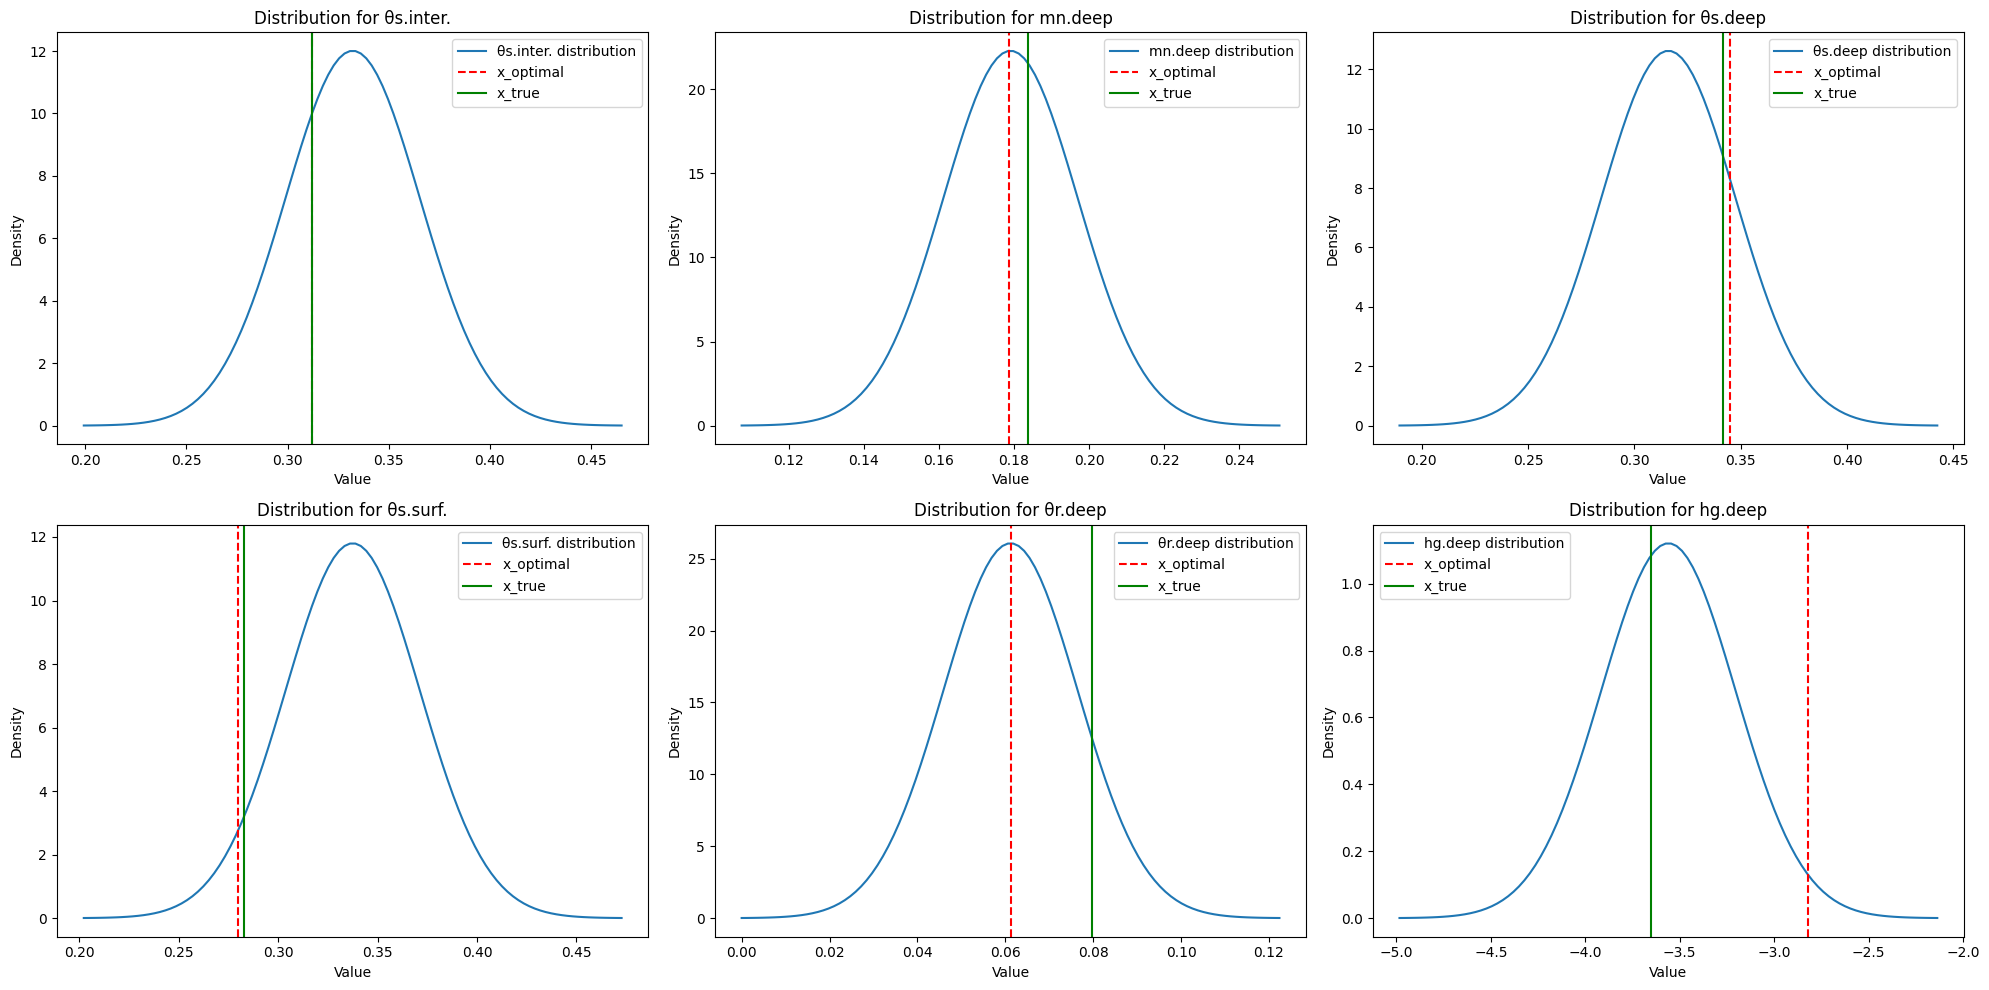

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm  

# Replace these with your actual x_true values
x_true_values = [0.312131485917921, 0.183627104095568, 0.341646050842506, 0.282666344420186, 0.0796466153304157, -3.65000481082266]  

# x_optimal values you provided earlier
x_optimal = [0.3121401536871561, 0.1786456301319416, 0.3447790791268736, 0.279840011079228, 0.061384639968157, -2.81895948290551]


# Replace these with the actual distributions for each parameter
param_distributions = [
    ('θs.inter.', 0.3322, 0.03322**2),
    ('mn.deep', 0.1791, 0.0179**2),
    ('θs.deep', 0.316, 0.0316**2),
    ('θs.surf.', 0.3375, 0.0338**2),
    ('θr.deep', 0.0612, 0.0153**2),
    ('hg.deep',-3.560000, 0.35600000**2)
]

# Determine the number of rows and columns
num_params = len(param_distributions)
num_cols = int(np.ceil(num_params / 2))  # Number of columns (2 rows)
num_rows = 2  # Number of rows

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 10))  # Adjust figsize as needed

# Flatten axes for easy iteration
axes = axes.flatten()

for ax, (name, mu, sigma2), x_opt, x_tru in zip(axes, param_distributions, x_optimal, x_true_values):
    # Plot the distribution
    sigma = np.sqrt(sigma2)  # Convert variance to standard deviation
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
    y = norm.pdf(x, mu, sigma)
    ax.plot(x, y, label=f'{name} distribution')
    
    # Plot the x_optimal and x_true values
    ax.axvline(x=x_opt, color='red', linestyle='--', label='x_optimal')
    ax.axvline(x=x_tru, color='green', linestyle='-', label='x_true')
    
    # Formatting
    ax.set_title(f'Distribution for {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()

# Remove any unused subplots
for ax in axes[num_params:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


**Data analyse : Prépa emploi**

**Étape 1 : Importation des Bibliothèques**

Nous allons utiliser les bibliothèques pandas, numpy, seaborn, matplotlib, et sklearn pour notre analyse.



In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


**Étape 2 : Chargement des Données**

Nous allons charger l'ensemble de données Iris depuis la bibliothèque seaborn.

In [3]:
# Charger l'ensemble de données Iris
iris = sns.load_dataset('iris')
print(iris.head())


   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


**Étape 3 : Exploration des Données**

Nous allons explorer les données pour comprendre leur structure et leur contenu.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None
       sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.057333      3.758000     1.199333
std        0.828066     0.435866      1.765298     0.762238
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.50000

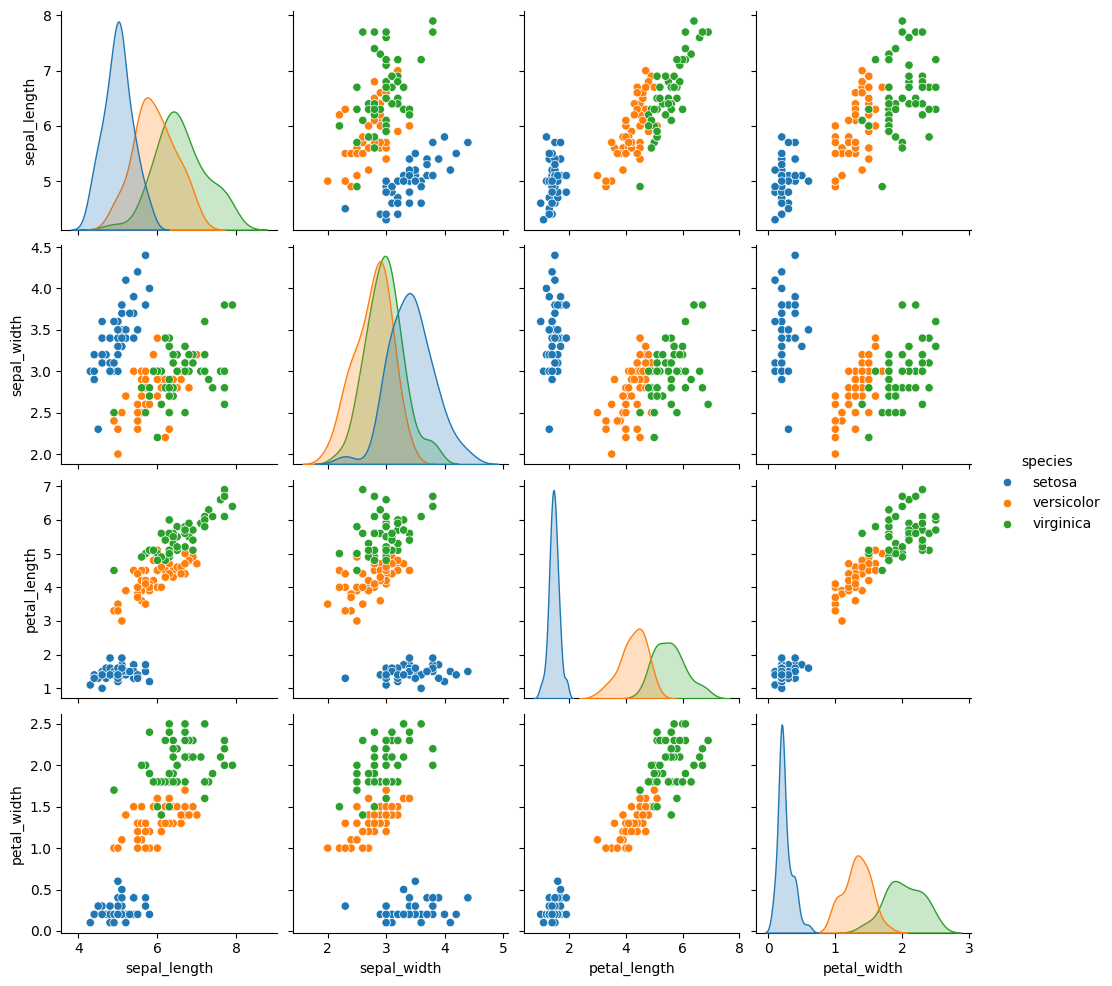

In [3]:
# Aperçu des données
print(iris.info())
print(iris.describe())

# Visualisation des distributions
sns.pairplot(iris, hue='species')
plt.show()

**Étape 4 : Préparation des Données**

Nous allons préparer les données pour la modélisation en séparant les caractéristiques (X) de la cible (y).

In [4]:
# Préparation des données
X = iris.drop('species', axis=1)
y = iris['species']
# Encodage des étiquettes de la cible
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)


**Étape 5 : Division des Données**

Nous allons diviser les données en ensembles d'entraînement et de test.

In [5]:
# Division des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


**Étape 6 : Modélisation**

Nous allons entraîner un modèle de régression logistique sur les données d'entraînement.

In [6]:
# Entraînement du modèle
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)


LogisticRegression(max_iter=200)

**Étape 7 : Évaluation du Modèle**

Nous allons évaluer les performances du modèle sur l'ensemble de test.

In [10]:
# Prédiction
y_pred = model.predict(X_test)

# Évaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]


**Étape 8 : Visualisation des Résultats**

Nous allons visualiser la matrice de confusion pour évaluer les performances du modèle.

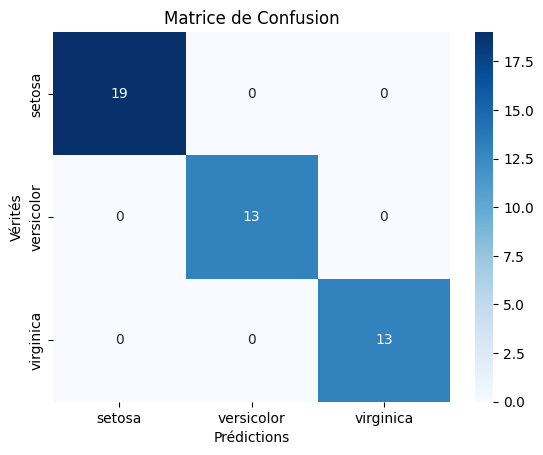

In [11]:
# Visualisation de la matrice de confusion
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.title('Matrice de Confusion')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

data = [1, 2, 2, 2, 3, 3, 4, 4, 4, 4.5, 5]

# Create histogram
plt.hist(data, bins=100, edgecolor='black')

# Add labels
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram with 4 bins')

# Show plot
plt.show()
